In [1]:
import numpy as np
import pandas as pd
import mysql.connector
import matplotlib.pyplot as plt
import squarify


In [2]:
#save key from keys.txt
with open('keys.txt') as f:
    lines = f.readlines()
    key = lines[0].strip()


In [3]:
db = mysql.connector.connect(host="localhost",
                             user="ramsus",
                             passwd=key,
                             database="pagos")


In [4]:
# Query to pandas dataframe for the sales per day
query = "SELECT DATE_FORMAT(fecha, '%W %M %d') AS dia, SUM(valor) AS total FROM pagos GROUP BY dia, fecha ORDER BY DATE(fecha)"
df = pd.read_sql(query, con=db)

/tmp/ipykernel_4741/1355553173.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, con=db)


In [5]:
df

,dia,total
0,Friday June 09,2065000.0
1,Saturday June 10,3240000.0
2,Wednesday June 14,1570000.0
3,Friday June 16,1615000.0
4,Tuesday June 20,830000.0
5,Thursday June 22,100000.0
6,Friday June 23,800000.0
7,Saturday June 24,1260000.0
8,Monday June 26,815000.0
9,Tuesday June 27,370000.0


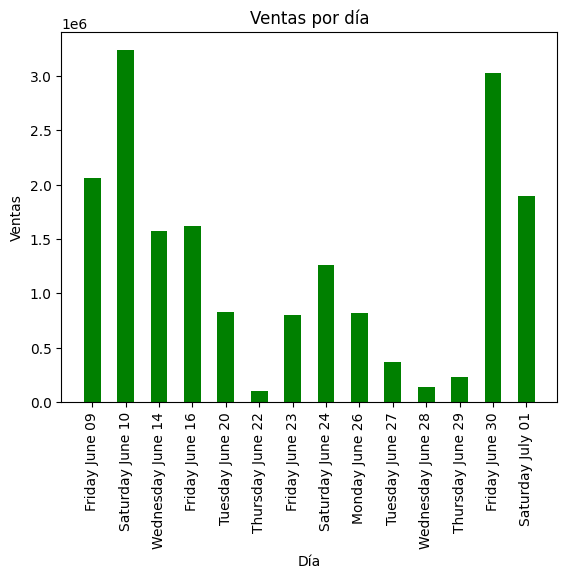

In [6]:
# create bar plot
plt.bar(df['dia'], df['total'], color='green', width=0.5)
plt.title('Ventas por día')
plt.xlabel('Día')
plt.ylabel('Ventas')
plt.xticks(rotation=90)
plt.show()


In [7]:
# mean sales per weekday
query = "SELECT DAYNAME(dia) AS weekday, AVG(sales) AS mean_sales FROM ( SELECT DATE(fecha) AS dia, SUM(valor) AS sales FROM pagos GROUP BY dia, fecha ORDER BY DATE(fecha) ) AS sales GROUP BY weekday ORDER BY FIELD(weekday, 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday')"
df = pd.read_sql(query, con=db)
df


/tmp/ipykernel_4741/2093718376.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, con=db)


,weekday,mean_sales
0,Monday,8.150000e+05
1,Tuesday,6.000000e+05
2,Wednesday,6.000000e+05
3,Thursday,1.650000e+05
4,Friday,1.877500e+06
5,Saturday,2.131667e+06


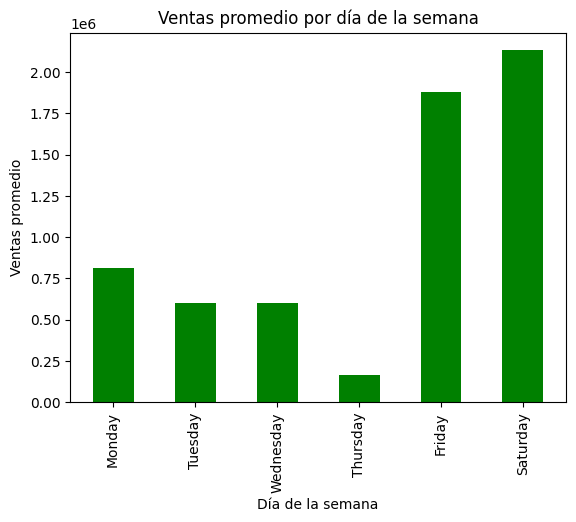

In [8]:
#bar plot
plt.bar(df['weekday'], df['mean_sales'], color='green', width=0.5)
plt.title('Ventas promedio por día de la semana')
plt.xlabel('Día de la semana')
plt.ylabel('Ventas promedio')
plt.xticks(rotation=90)
# set scale name as "millions"
plt.ticklabel_format(style='plain', axis='y')
plt.show()

In [9]:
query = "SELECT actividad, SUM(valor) AS total FROM pagos GROUP BY actividad ORDER BY total DESC"
df = pd.read_sql(query, con=db)
df

/tmp/ipykernel_4741/2391849971.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, con=db)


,actividad,total
0,lipopapada,3520000.0
1,bichectomia,2570000.0
2,control,1885000.0
3,protesis,1200000.0
4,"control, reparacion",1130000.0
5,"botox, hilos",1000000.0
6,"control, reparaciones",960000.0
7,retenedores,730000.0
8,hilos,690000.0
9,limpieza,520000.0


In [10]:
# add activity_1, activity_2 and activity_3 columns to dataframe 
df['activity_1'] = df['actividad'].str.split(',').str[0]
df['activity_2'] = df['actividad'].str.split(',').str[1]
df['activity_3'] = df['actividad'].str.split(',').str[2]

In [11]:
df

,actividad,total,activity_1,activity_2,activity_3
0,lipopapada,3520000.0,lipopapada,NaN,NaN
1,bichectomia,2570000.0,bichectomia,NaN,NaN
2,control,1885000.0,control,NaN,NaN
3,protesis,1200000.0,protesis,NaN,NaN
4,"control, reparacion",1130000.0,control,reparacion,NaN
5,"botox, hilos",1000000.0,botox,hilos,NaN
6,"control, reparaciones",960000.0,control,reparaciones,NaN
7,retenedores,730000.0,retenedores,NaN,NaN
8,hilos,690000.0,hilos,NaN,NaN
9,limpieza,520000.0,limpieza,NaN,NaN


In [12]:
# Función para normalizar una actividad
def normalizar_actividad(actividad):
    if actividad is np.nan:
        return actividad
    else:
        actividad = actividad.lower()
        actividad = actividad.replace("controles", "control")
        actividad = actividad.replace("reparaciones", "reparacion")
        actividad = actividad.replace("extracciones", "extraccion")
        return actividad

# Aplicar la función de normalización a la columna 'activity_1' y 'activity_2' si existe
df['activity_1'] = df['activity_1'].apply(normalizar_actividad)
df['activity_2'] = df['activity_2'].apply(normalizar_actividad)


In [13]:
# Lista de categorías principales
categorias_principales = ['lipopapada', 'control', 'bichectomia', 'protesis', 'retenedores', 'resinas', 'papada', 'montaje', 'braquets', 'extraccion']

# Función para realizar los cambios en las actividades
def modificar_actividades(row):
    # Verificar si alguna de las actividades está en las categorías principales
    if row['activity_2'] in categorias_principales:
        # Mover la actividad a activity_1 y actualizar el valor que estaba en activity_1
        row['activity_1'], row['activity_2'] = row['activity_2'], row['activity_1']
    elif row['activity_3'] in categorias_principales:
        # Mover la actividad a activity_1 y actualizar el valor que estaba en activity_1
        row['activity_1'], row['activity_3'] = row['activity_3'], row['activity_1']
    
    return row

# Aplicar la función a cada fila del DataFrame
df = df.apply(modificar_actividades, axis=1)


In [14]:
# drop "90: deuda" and "pago porcentaje" rows
df = df.drop(df[df['activity_1'] == '90: deuda'].index)
df = df.drop(df[df['activity_1'] == 'pago porcentaje'].index)

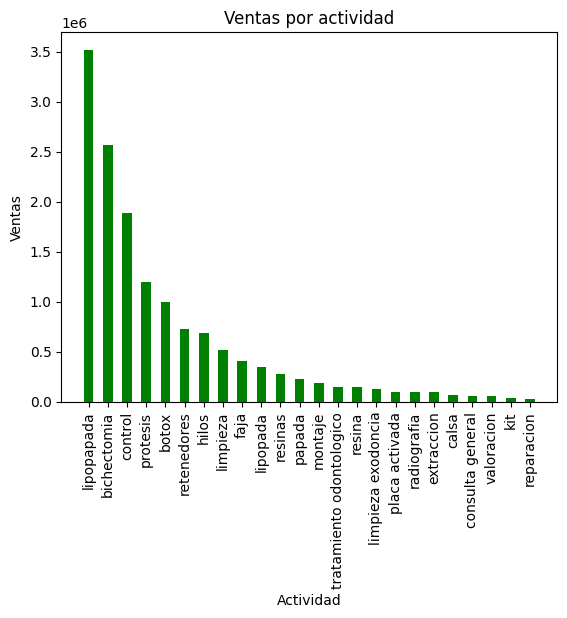

In [15]:
#plot bar chart for activity_1
plt.bar(df['activity_1'], df['total'], color='green', width=0.5)
plt.title('Ventas por actividad')
plt.xlabel('Actividad')
plt.ylabel('Ventas')
plt.xticks(rotation=90)
plt.show()

In [16]:
# sum values of total column
total = df['total'].sum()
total

18615000.0

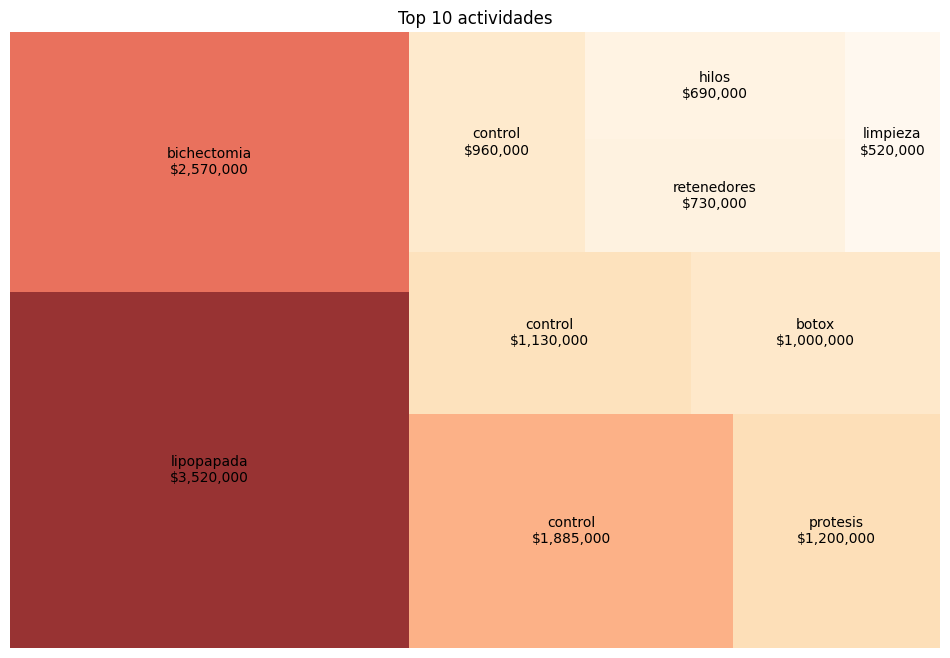

In [17]:
# make a treemap of top 10 activities and save the others in 'others' category
df['total'] = df['total'].astype(float)
# order by total
#df = df.sort_values(by='total', ascending=False)
#df.loc[~df['activity_1'].isin(df['activity_1'].value_counts().head(10).index), 'activity_1'] = 'others' 
#df = df.groupby('activity_1').sum()
#df = df.reset_index()

df = df.sort_values(by='total', ascending=False)
df = df.head(10)

# add "others" with the sum of the rest of the activities
df = df.append({'activity_1': 'others', 'total': total - df['total'].sum()}, ignore_index=True)
# create a color palette, mapped to these values 
cmap = plt.cm.OrRd
mini=min(df['total'])
maxi=max(df['total'])
norm = plt.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in df['total']]

# create labels inside the plot (total formatted as money)
labels = [str(i) + '\n' + str(j) for i, j in zip(df['activity_1'], df['total'].map('${:,.0f}'.format))]
# create plot
plt.figure(figsize=(12,8))
squarify.plot(sizes=df['total'], label=labels, alpha=.8, color=colors)
plt.title('Top 10 actividades')
plt.axis('off')
plt.show()


In [18]:
# sum values of total column
total = df['total'].sum()
total

14205000.0

In [19]:
df

,actividad,total,activity_1,activity_2,activity_3
0,lipopapada,3520000.0,lipopapada,NaN,NaN
1,bichectomia,2570000.0,bichectomia,NaN,NaN
2,control,1885000.0,control,NaN,NaN
3,protesis,1200000.0,protesis,NaN,NaN
4,"control, reparacion",1130000.0,control,reparacion,NaN
5,"botox, hilos",1000000.0,botox,hilos,NaN
6,"control, reparaciones",960000.0,control,reparacion,NaN
7,retenedores,730000.0,retenedores,NaN,NaN
8,hilos,690000.0,hilos,NaN,NaN
9,limpieza,520000.0,limpieza,NaN,NaN
